In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torchvision.models import resnet18
import os
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image

In [19]:
import segmentation_models_pytorch as smp

model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=1, classes=1)

In [20]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '_mask.png'))
        
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [21]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set hyperparameters
batch_size = 32
num_epochs = 100
learning_rate = 0.001

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = SegmentationDataset('/home/mmaddur1/Desktop/Segmentation01/train/org', '/home/mmaddur1/Desktop/Segmentation01/train/label', transform=transform)
val_dataset = SegmentationDataset('/home/mmaddur1/Desktop/Segmentation01/test/org', '/home/mmaddur1/Desktop/Segmentation01/test/label', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model, loss, and optimizer
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Save the model
torch.save(model.state_dict(), 'unet_grayscale.pth')



Epoch 1/100, Train Loss: 0.6087, Val Loss: 3.1591
Epoch 2/100, Train Loss: 0.4024, Val Loss: 10.8855
Epoch 3/100, Train Loss: 0.2801, Val Loss: 9.9405
Epoch 4/100, Train Loss: 0.2217, Val Loss: 10.7681
Epoch 5/100, Train Loss: 0.1941, Val Loss: 9.8271
Epoch 6/100, Train Loss: 0.1729, Val Loss: 6.8951
Epoch 7/100, Train Loss: 0.1578, Val Loss: 5.4501
Epoch 8/100, Train Loss: 0.1461, Val Loss: 3.0863
Epoch 9/100, Train Loss: 0.1340, Val Loss: 1.5825
Epoch 10/100, Train Loss: 0.1227, Val Loss: 1.0514
Epoch 11/100, Train Loss: 0.1142, Val Loss: 0.5356
Epoch 12/100, Train Loss: 0.1083, Val Loss: 0.3101
Epoch 13/100, Train Loss: 0.1008, Val Loss: 0.2112
Epoch 14/100, Train Loss: 0.0948, Val Loss: 0.1681
Epoch 15/100, Train Loss: 0.0888, Val Loss: 0.1242
Epoch 16/100, Train Loss: 0.0854, Val Loss: 0.1129
Epoch 17/100, Train Loss: 0.0814, Val Loss: 0.1084
Epoch 18/100, Train Loss: 0.0778, Val Loss: 0.1003
Epoch 19/100, Train Loss: 0.0727, Val Loss: 0.1139
Epoch 20/100, Train Loss: 0.0701, Val 

In [25]:
from torchmetrics import JaccardIndex

# Initialize the IoU metric
iou_metric = JaccardIndex(task="binary", num_classes=2)
iou_metric = iou_metric.to(device)  # Move to the same device as your model

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(outputs)
        # Convert probabilities to binary predictions
        preds = (probs > 0.5).float()
        # Here you can add code to calculate metrics or visualize results

In [27]:
model.eval()
total_iou = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        masks = masks.int()

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(outputs)
        
        # Convert probabilities to binary predictions
        preds = (probs > 0.5).int()
        
        # Calculate IoU for this batch
        batch_iou = iou_metric(preds, masks)
        total_iou += batch_iou
        num_batches += 1

average_iou = total_iou / num_batches
print(f'Average IoU: {average_iou:.4f}')

Average IoU: 0.9119


In [28]:
import matplotlib.pyplot as plt
import torch
import numpy as np

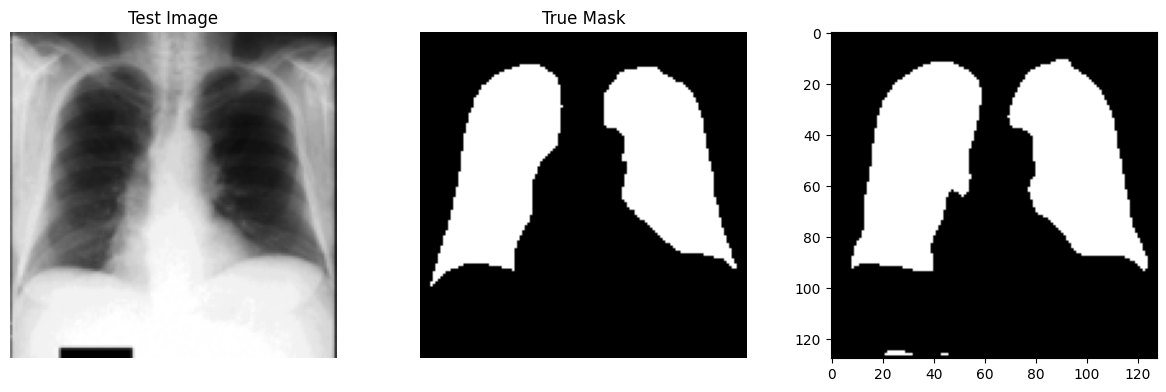

In [30]:
def visualize_predictions(images, true_masks, predicted_masks, iou_scores):
    num_samples = images.shape[0]
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i].squeeze().cpu(), cmap='gray')
        plt.title('Test Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i].squeeze().cpu(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i].squeeze().cpu(), cmap='gray')
        plt.title(f'Predicted Mask (IoU: {iou_scores[i]:.4f})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage in the evaluation loop
iou_scores = iou_metric(preds, masks)
visualize_predictions(images, masks, preds, iou_scores)